# Understanding Causal Inference with IHDP: From Theory to Practice

## 1. Introduction to Causal Inference

### 1.1 The Need for Causal Inference
![XKCD Comic](https://imgs.xkcd.com/comics/correlation_2x.png)
> ⚠️ **Key Concept**: Correlation does not imply causation

In predictive modeling, we often focus on finding correlations between variables. However, for decision-making, we need to understand the *causal* relationship between actions and outcomes.

The fundamental problem of causal inference is that we can never observe both potential outcomes for the same unit - we can't simultaneously observe what happens when a person receives a treatment and doesn't receive a treatment.

> *In causal inference, a confounder is a variable that affects both the treatment (or independent variable) and the outcome (or dependent variable), potentially creating a spurious association if not controlled for. For example, when studying the effect of alcohol consumption on lung cancer risk, smokers tend to drink more and smoking is a direct cause of lung cancer, so smoking acts as a confounder that can distort the observed relationship between alcohol and cancer.*

/opt/anaconda3/envs/getting_started_llmops/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


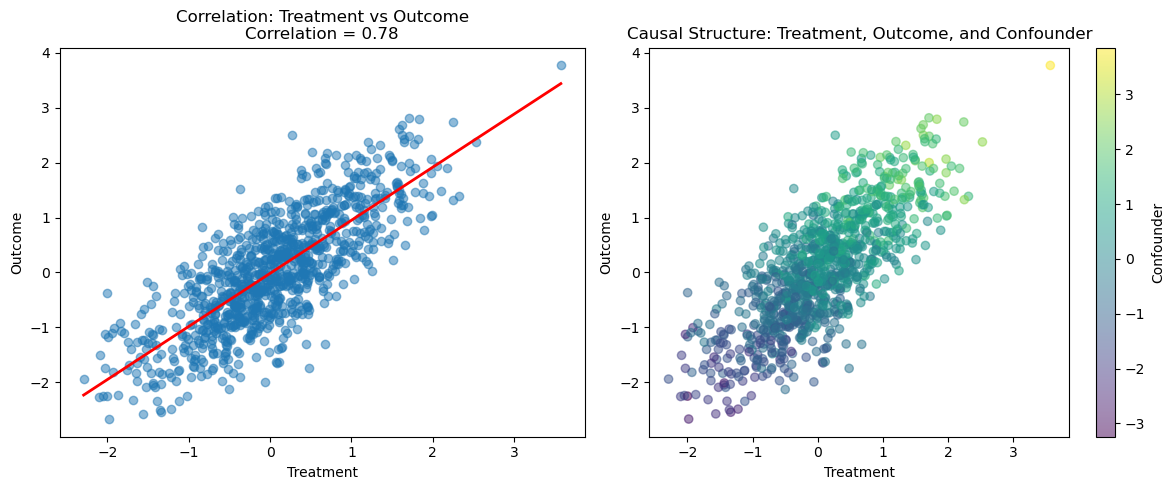

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set random seed for reproducibility
np.random.seed(42)

# Generate data to illustrate correlation vs causation
n = 1000
# Common cause (confounder)
confounder = np.random.normal(0, 1, n)
# Treatment influenced by confounder
treatment = 0.7 * confounder + np.random.normal(0, 0.5, n)
# Outcome influenced by both treatment and confounder
outcome = 0.3 * treatment + 0.7 * confounder + np.random.normal(0, 0.5, n)

# Create a DataFrame
data = pd.DataFrame({
    'Treatment': treatment,
    'Outcome': outcome,
    'Confounder': confounder
})

# Plot the data
plt.figure(figsize=(12, 5))

# Plot 1: Treatment vs Outcome (shows correlation)
plt.subplot(1, 2, 1)
plt.scatter(data['Treatment'], data['Outcome'], alpha=0.5)
# Fit a linear regression model
model = LinearRegression()
model.fit(data[['Treatment']], data['Outcome'])
# Add regression line
x_range = np.linspace(data['Treatment'].min(), data['Treatment'].max(), 100)
plt.plot(x_range, model.predict(x_range.reshape(-1, 1)), 'r-', linewidth=2)
plt.title('Correlation: Treatment vs Outcome\nCorrelation = {:.2f}'.format(
    np.corrcoef(data['Treatment'], data['Outcome'])[0, 1]))
plt.xlabel('Treatment')
plt.ylabel('Outcome')

# Plot 2: Treatment vs Outcome with confounder as color
plt.subplot(1, 2, 2)
plt.scatter(data['Treatment'], data['Outcome'], c=data['Confounder'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Confounder')
plt.title('Causal Structure: Treatment, Outcome, and Confounder')
plt.xlabel('Treatment')
plt.ylabel('Outcome')

plt.tight_layout()
plt.show()

**Analysis:** The first plot shows a strong correlation between treatment and outcome, which might lead us to conclude that the treatment causes the outcome. However, the second plot reveals that the confounder influences both treatment and outcome. When we condition on the confounder (shown by color), we see that the true causal effect of treatment on outcome is much weaker than the correlation suggests.

### 1.2 Real-World Applications

Causal inference is crucial in various domains:

#### Healthcare
- Evaluating treatment effectiveness
- Understanding disease progression
- Personalizing medical decisions

#### Policy
- Program evaluation
- Social interventions assessment
- Education policy design

#### Business
- Marketing strategy optimization
- Product feature evaluations
- Customer retention strategies

### 1.3 Key Concepts in Causal Inference

#### The Potential Outcomes Framework

Developed by Rubin, this framework formalizes causal inference through potential outcomes. For each unit i:
- Y_i(1): Outcome if unit i receives treatment
- Y_i(0): Outcome if unit i doesn't receive treatment

The individual treatment effect is defined as:

$$ \tau_i = Y_i(1) - Y_i(0) $$

However, we can only observe one of these outcomes for each unit, which is known as the **fundamental problem of causal inference**.

In [3]:
# Simple illustration of potential outcomes
np.random.seed(42)
n = 10  # Small sample for illustration

# True treatment effects (not observable in real settings)
true_effect = np.random.normal(5, 2, n)

# Potential outcomes
potential_outcomes = pd.DataFrame({
    'Unit': range(1, n+1),
    'Y(0)': np.random.normal(10, 3, n),                # Control outcome
    'Y(1)': np.random.normal(10, 3, n) + true_effect,  # Treated outcome
    'True_Effect': true_effect
})

# Randomly assign treatment
potential_outcomes['Treatment'] = np.random.binomial(1, 0.5, n)

# Observed outcomes (we only see one potential outcome per unit)
potential_outcomes['Observed_Y'] = np.where(
    potential_outcomes['Treatment'] == 1,
    potential_outcomes['Y(1)'],
    potential_outcomes['Y(0)']
)

print("Potential Outcomes Framework Illustration:")
print(potential_outcomes)

# What we can actually observe in real data
observed_data = potential_outcomes[['Unit', 'Treatment', 'Observed_Y']].copy()
print("\nWhat we actually observe in real data:")
print(observed_data)

Potential Outcomes Framework Illustration:
   Unit       Y(0)       Y(1)  True_Effect  Treatment  Observed_Y
0     1   8.609747  20.390375     5.993428          1   20.390375
1     2   8.602811  14.046142     4.723471          0    8.602811
2     3  10.725887  16.497962     6.295377          0   10.725887
3     4   4.260159  13.771815     8.046060          0    4.260159
4     5   4.825247  12.898545     4.531693          0    4.825247
5     6   8.313137  14.864494     4.531726          1   14.864494
6     7   6.961507  14.705445     8.158426          0    6.961507
7     8  10.942742  17.661964     6.534869          1   17.661964
8     9   7.275928  12.259135     4.061051          0    7.275928
9    10   5.763089  15.210039     6.085120          1   15.210039

What we actually observe in real data:
   Unit  Treatment  Observed_Y
0     1          1   20.390375
1     2          0    8.602811
2     3          0   10.725887
3     4          0    4.260159
4     5          0    4.825247
5    

#### Types of Treatment Effects

**Average Treatment Effect (ATE):**
The average effect of the treatment across the entire population.

$$ ATE = E[Y(1) - Y(0)] $$

**Conditional Average Treatment Effect (CATE):**
The average effect of the treatment conditional on specific covariates.

$$ CATE(X=x) = E[Y(1) - Y(0) | X=x] $$

**Average Treatment Effect on the Treated (ATT):**
The average effect among those who received the treatment.

$$ ATT = E[Y(1) - Y(0) | T=1] $$

In [4]:
# Calculate the different treatment effects
ate_true = potential_outcomes['True_Effect'].mean()
att_true = potential_outcomes.loc[potential_outcomes['Treatment'] == 1, 'True_Effect'].mean()

# Naive estimate (just comparing treated and control groups)
naive_ate = potential_outcomes.loc[potential_outcomes['Treatment'] == 1, 'Observed_Y'].mean() - \
            potential_outcomes.loc[potential_outcomes['Treatment'] == 0, 'Observed_Y'].mean()

print(f"True ATE: {ate_true:.2f}")
print(f"True ATT: {att_true:.2f}")
print(f"Naive ATE estimate: {naive_ate:.2f}")

True ATE: 5.90
True ATT: 5.79
Naive ATE estimate: 9.92


### 1.4 Key Assumptions in Causal Inference

1. **Unconfoundedness (Ignorability)**: Treatment assignment is independent of potential outcomes given observed covariates.
   
   $$ (Y(0), Y(1)) \perp T | X $$

2. **Positivity (Overlap)**: Every unit has a non-zero probability of receiving either treatment or control.
   
   $$ 0 < P(T=1|X=x) < 1 \text{ for all } x $$

3. **Stable Unit Treatment Value Assumption (SUTVA)**:
   - No interference: One unit's treatment doesn't affect another unit's outcome
   - No hidden variations of treatment

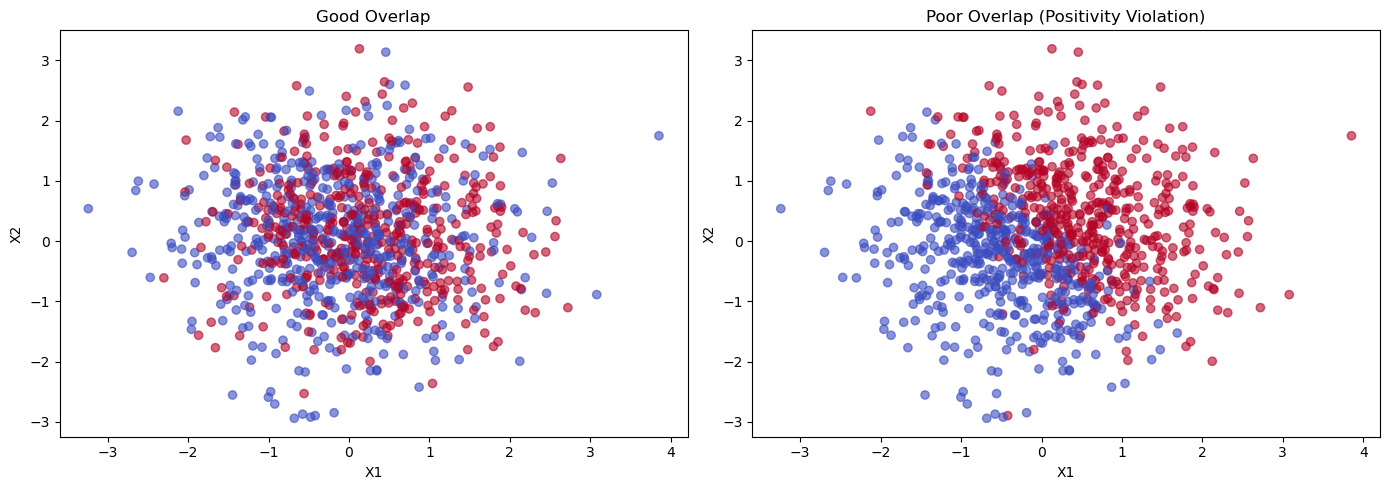

In [5]:
# Visualize the overlap assumption
np.random.seed(42)
n = 1000

# Create two features
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)

# Scenario 1: Good overlap
p_good = 1 / (1 + np.exp(-(0.5 * X1)))
treatment_good = np.random.binomial(1, p_good, n)

# Scenario 2: Poor overlap
p_poor = 1 / (1 + np.exp(-(3 * X1 + 2 * X2)))
treatment_poor = np.random.binomial(1, p_poor, n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Good overlap
axes[0].scatter(X1, X2, c=treatment_good, cmap='coolwarm', alpha=0.6)
axes[0].set_title('Good Overlap')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')

# Poor overlap
axes[1].scatter(X1, X2, c=treatment_poor, cmap='coolwarm', alpha=0.6)
axes[1].set_title('Poor Overlap (Positivity Violation)')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')

plt.tight_layout()
plt.show()

**Analysis:** The plots illustrate the positivity assumption. In the "Good Overlap" scenario, both treated (red) and control (blue) units exist across the entire covariate space. In the "Poor Overlap" scenario, there are regions with only treated or only control units, making it impossible to estimate treatment effects in those regions without extrapolation.

## Resources and References

- [Causal Inference: What If](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/) by Hernán & Robins
- [The Book of Why](http://bayes.cs.ucla.edu/WHY/) by Judea Pearl
- [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) - Python-focused tutorial
- [DoWhy Library Documentation](https://py-why.github.io/dowhy/)